<a href="https://colab.research.google.com/github/poojan14/AML-Practicals/blob/master/Practical_9_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Linear Discriminant Analysis (LDA)** is a dimensionality reduction technique. As the name implies dimensionality reduction techniques reduce the number of dimensions in a dataset while retaining as much information as possible. 

In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Categorical.from_codes(wine.target, wine.target_names)
X.shape


(178, 13)

In [3]:
X.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [4]:
wine.target_names


array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [0]:
df = X.join(pd.Series(y, name='class'))


**Steps for LDA:**

1)Compute the within class and between class scatter matrices

2Compute the eigenvectors and corresponding eigenvalues for the scatter matrices

3)Sort the eigenvalues and select the top k

4)Create a new matrix containing eigenvectors that map to the k eigenvalues

5)Obtain the new features (i.e. LDA components) by taking the dot product of the data and the matrix from step 4


In [6]:
class_feature_means = pd.DataFrame(columns=wine.target_names)
for c, rows in df.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means


,class_0,class_1,class_2
alcohol,13.744746,12.278732,13.153750
malic_acid,2.010678,1.932676,3.333750
ash,2.455593,2.244789,2.437083
alcalinity_of_ash,17.037288,20.238028,21.416667
magnesium,106.338983,94.549296,99.312500
total_phenols,2.840169,2.258873,1.678750
flavanoids,2.982373,2.080845,0.781458
nonflavanoid_phenols,0.290000,0.363662,0.447500
proanthocyanins,1.899322,1.630282,1.153542
color_intensity,5.528305,3.086620,7.396250


In [0]:
within_class_scatter_matrix = np.zeros((13,13))
for c, rows in df.groupby('class'):
  rows = rows.drop(['class'], axis=1)
    
  s = np.zeros((13,13))
for index, row in rows.iterrows():
        x, mc = row.values.reshape(13,1), class_feature_means[c].values.reshape(13,1)
        
        s += (x - mc).dot((x - mc).T)
    
within_class_scatter_matrix += s


In [0]:
feature_means = df.mean()
between_class_scatter_matrix = np.zeros((13,13))
for c in class_feature_means:    
    n = len(df.loc[df['class'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(13,1), feature_means.values.reshape(13,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)


In [0]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))


In [15]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])


237.46123198302251
46.98285938758684
1.4317197551638386e-14
1.2141209883217706e-14
1.2141209883217706e-14
8.279823065850476e-15
7.105427357601002e-15
6.0293733655173466e-15
6.0293733655173466e-15
4.737608877108813e-15
4.737608877108813e-15
2.4737196789039026e-15
9.84629525010022e-16


In [16]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))


Explained Variance
Eigenvector 0: 0.8348256799387275
Eigenvector 1: 0.1651743200612724
Eigenvector 2: 5.033396012077518e-17
Eigenvector 3: 4.268399397827047e-17
Eigenvector 4: 4.268399397827047e-17
Eigenvector 5: 2.9108789097898625e-17
Eigenvector 6: 2.498004906118145e-17
Eigenvector 7: 2.119704204950956e-17
Eigenvector 8: 2.119704204950956e-17
Eigenvector 9: 1.665567688286435e-17
Eigenvector 10: 1.665567688286435e-17
Eigenvector 11: 8.696681541121664e-18
Eigenvector 12: 3.4615924706522496e-18


First, we create a matrix W with the first two eigenvectors.


In [0]:
w_matrix = np.hstack((pairs[0][1].reshape(13,1), pairs[1][1].reshape(13,1))).real


In [0]:
X_lda = np.array(X.dot(w_matrix))
le = LabelEncoder()
y = le.fit_transform(df['class'])


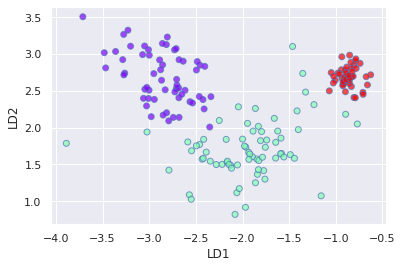

In [19]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)


In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

In [21]:
lda.explained_variance_ratio_


array([0.6875, 0.3125])

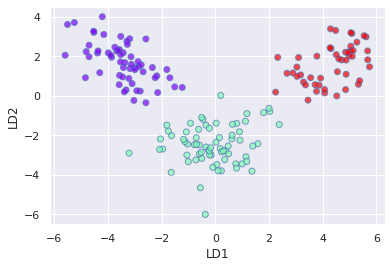

In [22]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)


Credit:- Cory Maklin(towardsdtatscience)